In [2]:
import torch
import keras
from sklearn.model_selection import train_test_split

# IMDB 데이터셋 
(train_input, train_target), (test_input, test_target) =\
     keras.datasets.imdb.load_data(num_words=500)

# 훈련세트, 검증세트
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

In [3]:
# 패딩 처리
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [4]:
print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [5]:
# 파이토치 torch.tensor 자료형으로 변환 
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [6]:
train_target.dtype

dtype('int64')

In [7]:
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [8]:
train_target.dtype

torch.float32

In [9]:
#  TensorDataset, DataLoader 
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

# 32개의 배치로 섞어서 나눠준다.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
# 층 구성 - nn.Module 클래스 상속을 통한 층 구성
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__() 
        self.embedding = nn.Embedding(500, 16)
        self.rnn = nn.RNN(16, 8, batch_first=True) # (시퀀스 길이, 배치크기, 임베딩크기) 
                                # (배치크기, 시퀀스 길이, 임베딩크기)
        self.dense = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)


In [15]:
from torchinfo import summary
model = IMDBRnn()

summary(model)


Layer (type:depth-idx)                   Param #
IMDBRnn                                  --
├─Embedding: 1-1                         8,000
├─RNN: 1-2                               208
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 8,217
Trainable params: 8,217
Non-trainable params: 0

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [20]:
# 옵티마이저, 손실함수
import torch.optim as optim

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters())

In [24]:
train_hist = []
val_hist = []
patience = 3
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets) # outputs.squeeze(): 2 차원배열 -> 1차원 배열
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()  
    
    train_loss = train_loss / len(train_loader) # 1에포크 평균 훈련 손실값
    val_loss = val_loss / len(val_loader) 
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1}, 훈련손실: {train_loss:.4f}, 검증손실: {val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}에서 조기 종료..")
            break


에포크:1, 훈련손실: 0.6840, 검증손실: 0.6794
에포크:2, 훈련손실: 0.6615, 검증손실: 0.6472
에포크:3, 훈련손실: 0.6323, 검증손실: 0.6160
에포크:4, 훈련손실: 0.6137, 검증손실: 0.6075
에포크:5, 훈련손실: 0.6048, 검증손실: 0.6139
에포크:6, 훈련손실: 0.6111, 검증손실: 0.6062
에포크:7, 훈련손실: 0.5797, 검증손실: 0.6046
에포크:8, 훈련손실: 0.5938, 검증손실: 0.6241
에포크:9, 훈련손실: 0.5745, 검증손실: 0.6537
에포크:10, 훈련손실: 0.5877, 검증손실: 0.5826
에포크:11, 훈련손실: 0.5674, 검증손실: 0.5799
에포크:12, 훈련손실: 0.5829, 검증손실: 0.6110
에포크:13, 훈련손실: 0.5822, 검증손실: 0.5837
에포크:14, 훈련손실: 0.5706, 검증손실: 0.5864
14에서 조기 종료..


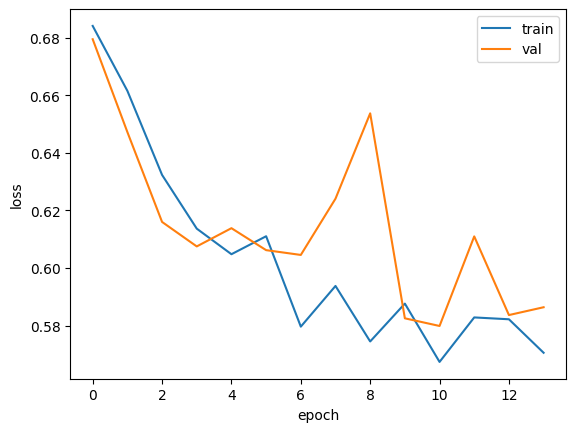

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


In [26]:
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

<All keys matched successfully>

In [27]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.7054
